In [1]:
%load_ext autoreload
%autoreload 2
import sys, os

In [3]:
import os
os.chdir('..')  # Move up one directory level

In [4]:
import glob, os
import mediapy as media
import torch
from torch.utils.data import DataLoader

from mcvd_pytorch.load_model_from_ckpt import load_model, get_readout_sampler, init_samples
from mcvd_pytorch.datasets import get_dataset, data_transform, inverse_data_transform
from mcvd_pytorch.runners.ncsn_runner import conditioning_fn

from os.path import expanduser
home = expanduser("~")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load model checkpoint

In [31]:
model_path = '/ccn2/u/thekej/ego4d_pretrain_mcvd/model_12_1/logs/'#'/ccn2/u/thekej/ucf10132_big192_288_4c4_unetm_spade/logs/'
ckpt_path = glob.glob(os.path.join(model_path, "checkpoint_100000.pt"))[0]

# load model
scorenet, config = load_model(ckpt_path, device)
# get sampler
sampler = get_readout_sampler(config)

In [32]:
print(device)
print(ckpt_path)
print(config)

cuda
/ccn2/u/thekej/ego4d_pretrain_mcvd/model_12_1/logs/checkpoint_100000.pt
Namespace(data=Namespace(channels=3, color_jitter=0.0, dataset='EGO4D', gaussian_dequantization=False, image_size=64, logit_transform=False, num_frames=1, num_frames_cond=12, num_frames_future=0, num_workers=4, prob_mask_cond=0.0, prob_mask_future=0.0, prob_mask_sync=False, random_flip=True, rescaled=True, uniform_dequantization=False), device=device(type='cuda'), fast_fid=Namespace(batch_size=1000, begin_ckpt=5000, end_ckpt=300000, ensemble=False, freq=5000, n_steps_each=0, num_samples=1000, pr_nn_k=3, step_lr=0.0, verbose=False), model=Namespace(arch='unetmore', attn_resolutions=[8, 16, 32], ch_mult=[1, 2, 3, 4], cond_emb=False, conditional=True, depth='deeper', dropout=0.1, ema=True, ema_rate=0.999, gamma=False, n_head_channels=96, ngf=192, noise_in_cond=False, nonlinearity='swish', normalization='InstanceNorm++', num_classes=1000, num_res_blocks=2, output_all_frames=False, sigma_begin=0.02, sigma_dist='lin

# Load data

In [33]:
from datasets.physion import PhysionDataset

In [86]:
def get_dataset(config):
    
    frames_per_sample = 48
    dataset = PhysionDataset('/ccn2/u/thekej/mcvd_physion_readout/train/shard_0001.hdf5', 
                             frames_per_sample=frames_per_sample, 
                             image_size=config.data.image_size, train=False, random_time=True,
                             random_horizontal_flip=False,
                             complete=True,
                             simulation=False) #change this

    return dataset

In [87]:
def inverse_transform(config, X):
    X = X.to('cpu')
    if hasattr(config, 'image_mean'):
        X = X + config.image_mean.to(X.device)[None, ...]

    if config.data.logit_transform:
        X = torch.sigmoid(X)
    elif config.data.rescaled:
        X = (X + 1.) / 2.
    return torch.clamp(X, 0.0, 1.0)

In [88]:
dataset = get_dataset(config)

Checking shard_lengths in ['/ccn2/u/thekej/mcvd_physion_readout/train/shard_0001.hdf5']
h5: Opening /ccn2/u/thekej/mcvd_physion_readout/train/shard_0001.hdf5... h5: paths 1 ; shard_lengths [5608] ; total 5608
Dataset length: 5608


In [89]:
test_loader = DataLoader(dataset, batch_size=1, shuffle=True,#config.training.batch_size, shuffle=False,
                         num_workers=config.data.num_workers, drop_last=True)
test_iter = iter(test_loader)
test_x, test_y = next(test_iter)
print(test_x.shape)
test_x = data_transform(config, test_x)


torch.Size([1, 48, 3, 64, 64])


In [90]:

real, cond, cond_mask = conditioning_fn(config, test_x, num_frames_pred=config.data.num_frames,
                                        prob_mask_cond=getattr(config.data, 'prob_mask_cond', 0.0),
                                        prob_mask_future=getattr(config.data, 'prob_mask_future', 0.0))
print(real.shape, cond.shape)

torch.Size([1, 3, 64, 64]) torch.Size([1, 36, 64, 64])


# Load initial samples

In [91]:
init = init_samples(len(real), config)

torch.Size([1, 3, 64, 64]) torch.Size([3, 64, 64])


,,

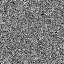
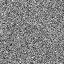
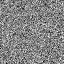

In [92]:
i = 0
print(init.shape, init[i].shape)
media.show_images(init[i])

# Predict

In [93]:
import numpy as np

In [96]:
preds = []
conds = [cond[0]]
print('stimuli images:')
#media.show_images(inverse_transform(config, cond[0]), height=200)
print('simulation images:')
for i in range(5):
    init = init_samples(len(real), config)
    pred, gamma, beta, mid = sampler(init, scorenet, cond=cond, cond_mask=cond_mask, subsample=300, verbose=False)
    #show_video(pred[0], config)
    #media.show_images(inverse_transform(config, pred[0] + 0.2), height=200)
    cond = torch.cat((cond[:, 3:, :, :], pred), dim=1)
    
    preds.append(pred[0])

stimuli images:
simulation images:


stimuli images:


,,,,,,,,,,,

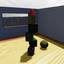
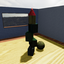
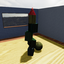
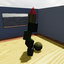
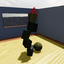
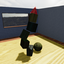
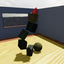
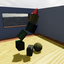
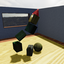
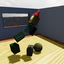
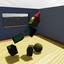
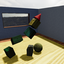

simulation images:
RGB


,,,,

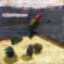
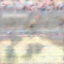
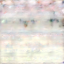
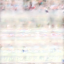
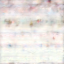

In [95]:
print('stimuli images:')
rgb = inverse_transform(config, conds[0]).reshape(12, 3, 64, 64)

media.show_images(rgb.permute(0,2,3,1), height=200)
print('simulation images:')
l, b, c = [], [], []
for i in range(5):
    pred = preds[i]#inverse_transform(config, preds[i])
    pred = pred.reshape(1, 3, 64, 64) # 
    l.append(pred.permute(0,2,3,1))
    
im = np.stack(l).reshape(-1, 64, 64, 3)
print('RGB')
media.show_images(im, height=200)

stimuli images:


,,,,,,,,,,,

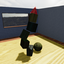
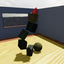
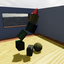
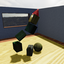
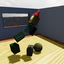
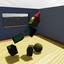
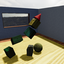
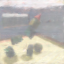
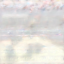
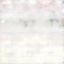
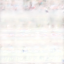
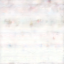

simulation images:
RGB


,,,,

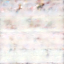
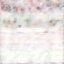
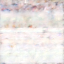
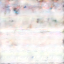
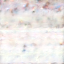

In [97]:
print('stimuli images:')
rgb = inverse_transform(config, conds[0]).reshape(12, 3, 64, 64)

media.show_images(rgb.permute(0,2,3,1), height=200)
print('simulation images:')
l, b, c = [], [], []
for i in range(5):
    pred = preds[i]#inverse_transform(config, preds[i])
    pred = pred.reshape(1, 3, 64, 64) # 
    l.append(pred.permute(0,2,3,1))
    
im = np.stack(l).reshape(-1, 64, 64, 3)
print('RGB')
media.show_images(im, height=200)

stimuli images:


,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

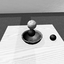
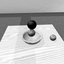
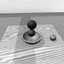
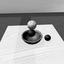
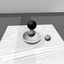
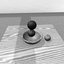
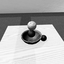
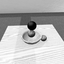
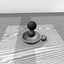
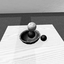
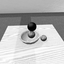
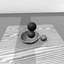
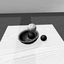
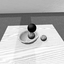
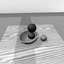
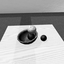
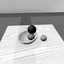
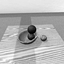
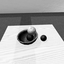
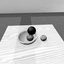
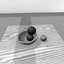
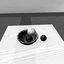
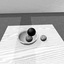
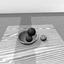
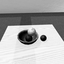
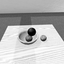
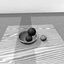
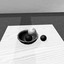
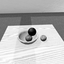
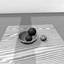
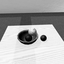
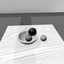
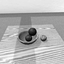
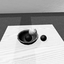
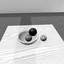
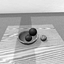

simulation images:
channel 1


,,,,,,,,,,,,

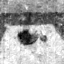
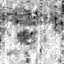
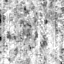
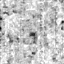
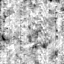
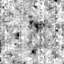
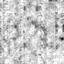
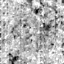
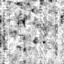
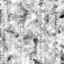
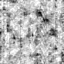
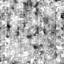
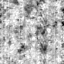

channel 2


,,,,,,,,,,,,

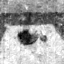
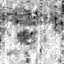
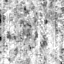
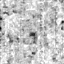
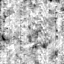
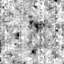
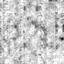
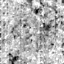
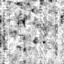
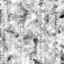
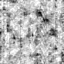
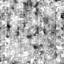
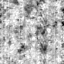

channel 3


,,,,,,,,,,,,

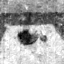
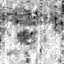
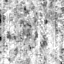
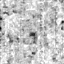
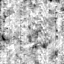
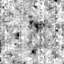
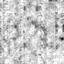
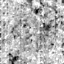
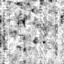
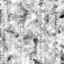
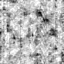
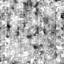
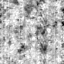

In [20]:
import numpy as np
print('stimuli images:')
media.show_images(inverse_transform(config, conds[0]), height=200)
print('simulation images:')
l, b, c = [], [], []
for i in range(13):
    pred = inverse_transform(config, preds[i])
    pred = pred.reshape(1, 3, 64, 64) # pred.permute(0,2,3,1)
    l.append(pred[:, 0])
    b.append(pred[:, 1])
    c.append(pred[:, 2])
im = np.stack(l).reshape(-1, 64, 64)
im1 = np.stack(b).reshape(-1, 64, 64)
im2 = np.stack(c).reshape(-1, 64, 64)

print('channel 1')
media.show_images(im, height=100)
print('channel 2')
media.show_images(im, height=100)
print('channel 3')
media.show_images(im, height=100)

stimuli images:


,,,,,,,,,,,

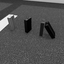
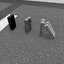
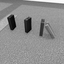
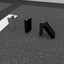
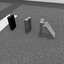
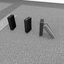
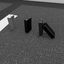
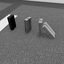
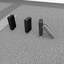
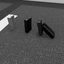
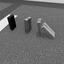
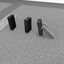

simulation images:
channel 1


,,,,,,,,,,,,,,,,,,,

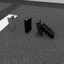
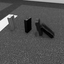
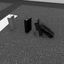
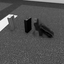
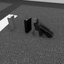
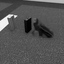
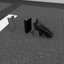
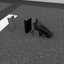
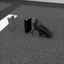
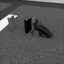
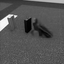
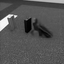
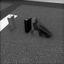
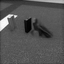
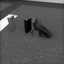
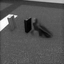
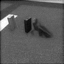
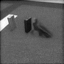
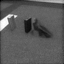
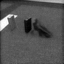

channel 2


,,,,,,,,,,,,,,,,,,,

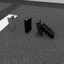
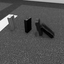
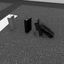
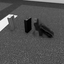
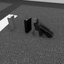
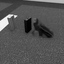
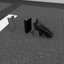
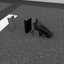
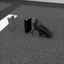
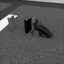
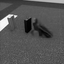
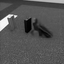
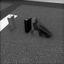
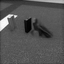
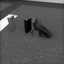
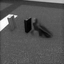
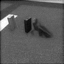
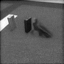
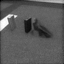
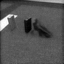

channel 3


,,,,,,,,,,,,,,,,,,,

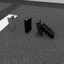
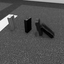
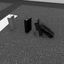
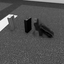
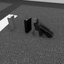
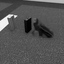
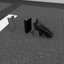
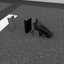
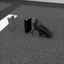
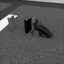
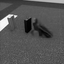
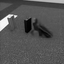
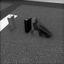
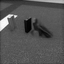
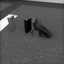
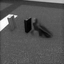
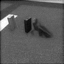
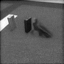
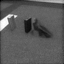
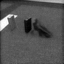

In [50]:
import numpy as np
print('stimuli images:')
media.show_images(inverse_transform(config, conds[0]), height=200)
print('simulation images:')
l, b, c = [], [], []
for i in range(5):
    pred = inverse_transform(config, preds[i])
    pred = pred.reshape(4, 3, 64, 64) # pred.permute(0,2,3,1)
    l.append(pred[:, 0])
    b.append(pred[:, 1])
    c.append(pred[:, 2])
im = np.stack(l).reshape(-1, 64, 64)
im1 = np.stack(b).reshape(-1, 64, 64)
im2 = np.stack(c).reshape(-1, 64, 64)

print('channel 1')
media.show_images(im, height=100)
print('channel 2')
media.show_images(im, height=100)
print('channel 3')
media.show_images(im, height=100)

stimuli images:


,,,

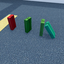
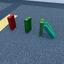
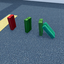
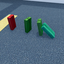

simulation images:
RGB


,,,,,,,,,,,,,,,,,,,

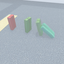
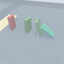
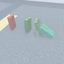
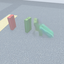
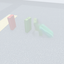
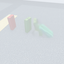
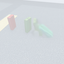
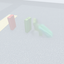
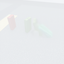
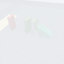
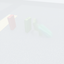
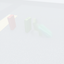
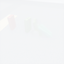
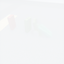
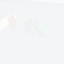
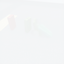
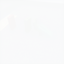
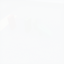
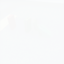
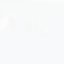

In [51]:
print('stimuli images:')
rgb = inverse_transform(config, conds[0]).reshape(4, 3, 64, 64)

media.show_images(rgb.permute(0,2,3,1), height=200)
print('simulation images:')
l, b, c = [], [], []
for i in range(5):
    pred = inverse_transform(config, preds[i])
    pred = pred.reshape(4, 3, 64, 64) # 
    l.append(pred.permute(0,2,3,1))
    
im = np.stack(l).reshape(-1, 64, 64, 3)
print('RGB')
media.show_images(im, height=200)

stimuli images:


,,,,,,,,,,,

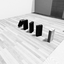
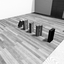
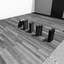
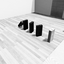
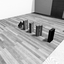
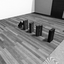
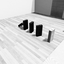
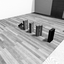
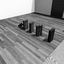
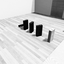
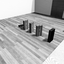
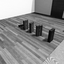

simulation images:
channel 1


,,,,,,,,,,,,,,,,,,,,,,,

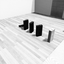
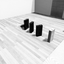
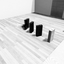
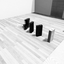
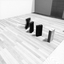
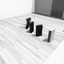
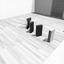
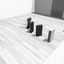
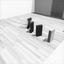
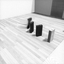
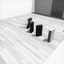
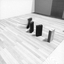
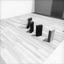
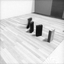
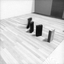
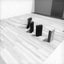
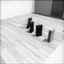
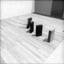
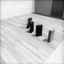
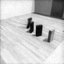
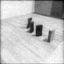
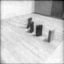
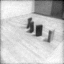
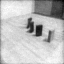

channel 2


,,,,,,,,,,,,,,,,,,,,,,,

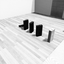
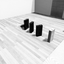
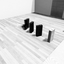
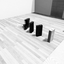
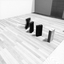
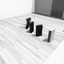
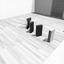
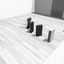
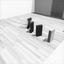
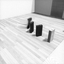
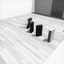
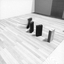
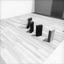
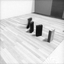
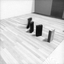
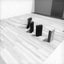
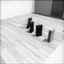
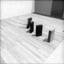
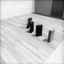
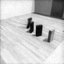
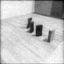
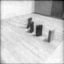
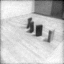
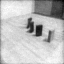

channel 3


,,,,,,,,,,,,,,,,,,,,,,,

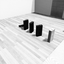
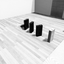
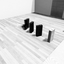
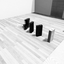
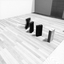
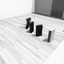
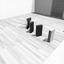
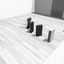
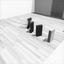
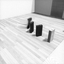
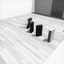
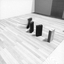
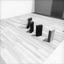
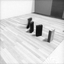
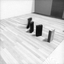
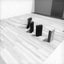
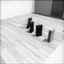
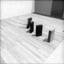
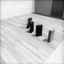
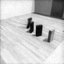
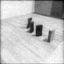
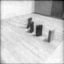
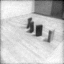
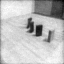

In [57]:
import numpy as np
print('stimuli images:')
media.show_images(inverse_transform(config, conds[0]), height=200)
print('simulation images:')
l, b, c = [], [], []
for i in range(6):
    pred = inverse_transform(config, preds[i])
    pred = pred.reshape(4, 3, 64, 64) # pred.permute(0,2,3,1)
    l.append(pred[:, 0])
    b.append(pred[:, 1])
    c.append(pred[:, 2])
im = np.stack(l).reshape(-1, 64, 64)
im1 = np.stack(b).reshape(-1, 64, 64)
im2 = np.stack(c).reshape(-1, 64, 64)

print('channel 1')
media.show_images(im, height=100)
print('channel 2')
media.show_images(im, height=100)
print('channel 3')
media.show_images(im, height=100)

stimuli images:


,,,

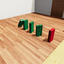
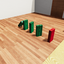
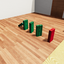
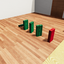

simulation images:
RGB


,,,,,,,,,,,,,,,,,,,,,,,

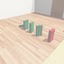
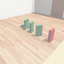
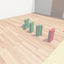
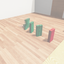
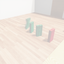
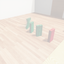
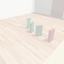
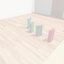
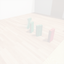
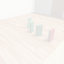
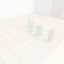
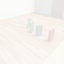
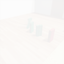
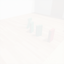
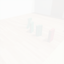
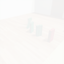
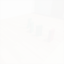
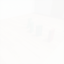
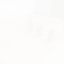
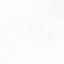
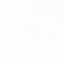
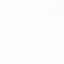
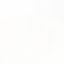
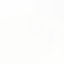

In [58]:
print('stimuli images:')
rgb = inverse_transform(config, conds[0]).reshape(4, 3, 64, 64)

media.show_images(rgb.permute(0,2,3,1), height=200)
print('simulation images:')
l, b, c = [], [], []
for i in range(6):
    pred = inverse_transform(config, preds[i])
    pred = pred.reshape(4, 3, 64, 64) # 
    l.append(pred.permute(0,2,3,1))
    
im = np.stack(l).reshape(-1, 64, 64, 3)
print('RGB')
media.show_images(im, height=200)